In [131]:
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import random
from math import radians, sin, cos, sqrt, asin
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from math import atan2, degrees

In [132]:
good_dir = Path(r'C:\Users\Lenovo\Downloads\extract\Examples_ADSB_Good')

In [133]:
bad_dir =  Path(r'C:\Users\Lenovo\Downloads\extract\Examples_ADSB_Bad')

In [134]:
good_files = sorted(good_dir.glob("*.npy"))
bad_files = sorted(bad_dir.glob("*.npy"))

In [135]:
good_trajectories = [np.load(f) for f in good_files]
bad_trajectories = [np.load(f) for f in bad_files]

In [136]:
print(f"Loaded {len(good_trajectories)} good and {len(bad_trajectories)} bad trajectories.")
print(f"Each trajectory shape: {good_trajectories[0].shape}")

Loaded 1000 good and 1000 bad trajectories.
Each trajectory shape: (20, 4)


In [137]:
columns = ["timestamp", "latitude", "longitude", "altitude_FL"]
example_good = good_trajectories[999]
example_bad = bad_trajectories[999]

In [138]:
print("Good example:")
display(pd.DataFrame(example_good, columns=columns).head())

print("Bad example:")
display(pd.DataFrame(example_bad, columns=columns).head())

Good example:


,timestamp,latitude,longitude,altitude_FL
0,1.646094e+09,51.0569,7.0168,1112.52
1,1.646094e+09,51.0563,7.0134,1097.28
2,1.646094e+09,51.0535,6.9997,1043.94
3,1.646094e+09,51.0520,6.9918,1005.84
4,1.646094e+09,51.0498,6.9815,960.12


Bad example:


,timestamp,latitude,longitude,altitude_FL
0,1.646093e+09,50.7890,5.5286,960.12
1,1.646093e+09,50.7888,5.6058,830.58
2,1.646093e+09,50.7888,5.6043,838.20
3,1.646093e+09,50.7406,5.6094,792.48
4,1.646093e+09,50.7888,5.6058,830.58


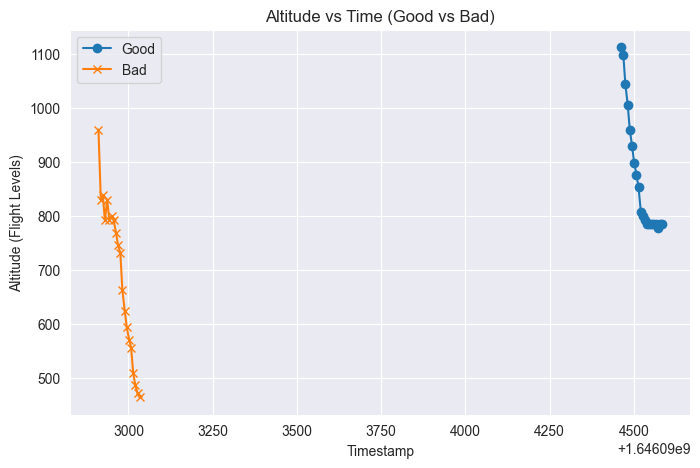

In [139]:
plt.figure(figsize=(8, 5))
plt.plot(example_good[:, 0], example_good[:, 3], 'o-', label='Good')
plt.plot(example_bad[:, 0], example_bad[:, 3], 'x-', label='Bad')
plt.xlabel("Timestamp")
plt.ylabel("Altitude (Flight Levels)")
plt.title("Altitude vs Time (Good vs Bad)")
plt.legend()
plt.grid(True)
plt.show()

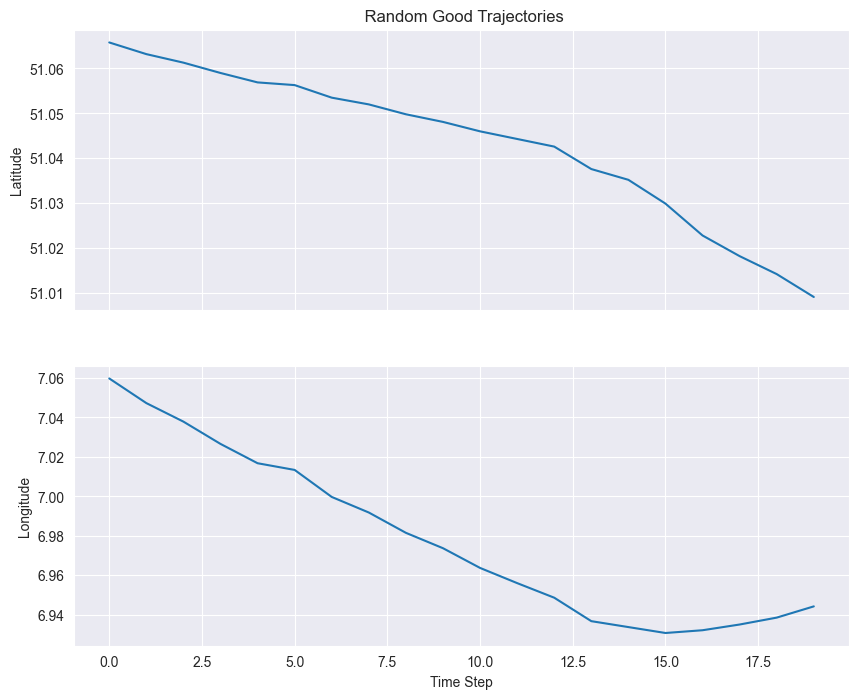

In [140]:
plt.show()
num_to_plot = 1
samples = random.sample(good_trajectories, num_to_plot)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

for traj in samples:
    time = range(len(traj))
    axes[0].plot(time, traj[:, 1], color='tab:blue')
    axes[1].plot(time, traj[:, 2], color='tab:blue')

axes[0].set_ylabel("Latitude")
axes[0].set_title(f" Random Good Trajectories")

axes[1].set_ylabel("Longitude")
axes[1].set_xlabel("Time Step")

for ax in axes:
    ax.grid(True)

plt.show()


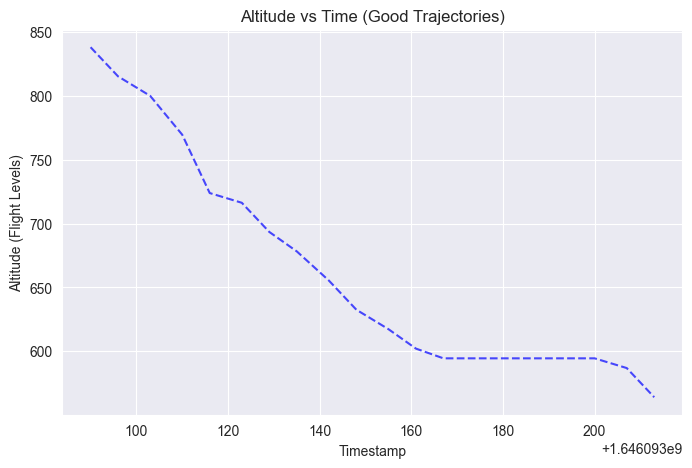

In [141]:
plt.figure(figsize=(8, 5))
for traj in random.sample(good_trajectories, 1):
    plt.plot(traj[:, 0], traj[:, 3], 'b--', alpha=0.7)

plt.title("Altitude vs Time (Good Trajectories)")
plt.xlabel("Timestamp")
plt.ylabel("Altitude (Flight Levels)")
plt.grid(True)
plt.show()

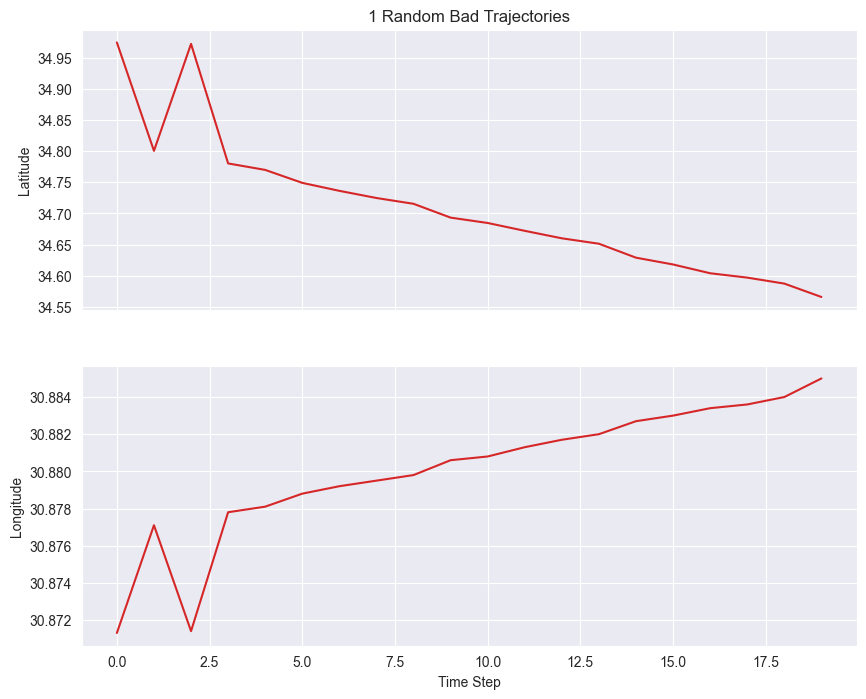

In [142]:
plt.show()
num_to_plot = 1
samples = random.sample(bad_trajectories, num_to_plot)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

for traj in samples:
    time = range(len(traj))
    axes[0].plot(time, traj[:, 1], color='tab:red')
    axes[1].plot(time, traj[:, 2], color='tab:red')

axes[0].set_ylabel("Latitude")
axes[0].set_title(f"{num_to_plot} Random Bad Trajectories")

axes[1].set_ylabel("Longitude")
axes[1].set_xlabel("Time Step")

for ax in axes:
    ax.grid(True)

plt.show()

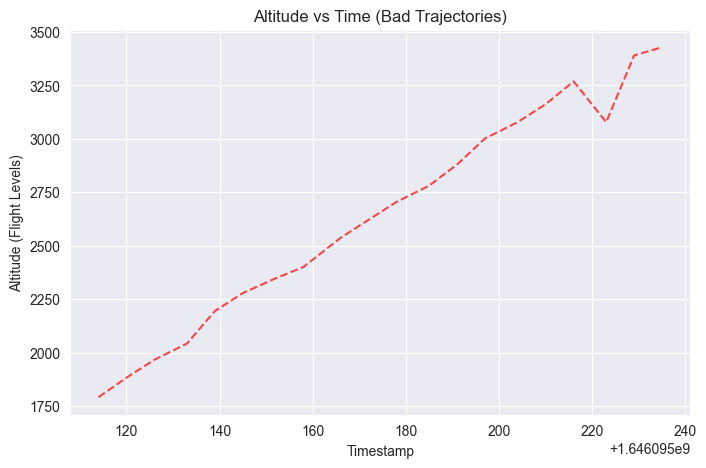

In [143]:
plt.figure(figsize=(8, 5))
for traj in random.sample(bad_trajectories, 1):
    plt.plot(traj[:, 0], traj[:, 3], 'r--', alpha=0.7)

plt.title("Altitude vs Time (Bad Trajectories)")
plt.xlabel("Timestamp")
plt.ylabel("Altitude (Flight Levels)")
plt.grid(True)
plt.show()

In [144]:
#Function that will help me with calculating the distance between two points in a trajectory
#using Haversine distance calculated in meters(m)
def haversine_m(lat1, lon1, lat2, lon2):
    R = 6371000.0
    phi1, phi2 = map(radians, (lat1, lat2))
    dphi = radians(lat2 - lat1)
    dlambda = radians(lon2 - lon1)
    a = sin(dphi/2)**2 + cos(phi1)*cos(phi2)*sin(dlambda/2)**2
    return 2 * R * asin(min(1, sqrt(a)))

In [145]:
#Function that returns a dataframe with imputed distance, time difference, horizontal speed and vertical rate in every row (between every consecutive point)
def pointwise(traj):
    #Return DataFrame with ts,lat,lon,alt_FL,dt,dist_m,speed_m_s,vertical_rate_FL_s
    df = pd.DataFrame(traj, columns=['t','lat','lon','alt_FL']).astype(float)
    df['dt'] = df['t'].diff().fillna(1.0)
    # distances
    dists = [0.0]
    for i in range(1, len(df)):
        dists.append(haversine_m(df.loc[i-1,'lat'], df.loc[i-1,'lon'],
                                 df.loc[i,'lat'], df.loc[i,'lon']))
    df['dist_m'] = dists
    # speeds
    df['speed_m_s'] = df['dist_m'] / df['dt'].replace(0, np.nan)
    df['speed_m_s'] = df['speed_m_s'].fillna(0.0)
    # vertical rate
    df['vertical_rate_FL_s'] = df['alt_FL'].diff() / df['dt'].replace(0, np.nan)
    df['vertical_rate_FL_s'] = df['vertical_rate_FL_s'].fillna(0.0)
    return df

In [146]:
df_example_1 = pointwise(example_good)
display(df_example_1.head())

,t,lat,lon,alt_FL,dt,dist_m,speed_m_s,vertical_rate_FL_s
0,1.646094e+09,51.0569,7.0168,1112.52,1.0,0.000000,0.000000,0.000000
1,1.646094e+09,51.0563,7.0134,1097.28,6.0,246.820246,41.136708,-2.540000
2,1.646094e+09,51.0535,6.9997,1043.94,6.0,1006.898465,167.816411,-8.890000
3,1.646094e+09,51.0520,6.9918,1005.84,7.0,576.831908,82.404558,-5.442857
4,1.646094e+09,51.0498,6.9815,960.12,6.0,760.398957,126.733160,-7.620000


In [147]:
df_example_2 = pointwise(example_bad)
display(df_example_2.head())

,t,lat,lon,alt_FL,dt,dist_m,speed_m_s,vertical_rate_FL_s
0,1.646093e+09,50.7890,5.5286,960.12,1.0,0.000000,0.000000,0.000000
1,1.646093e+09,50.7888,5.6058,830.58,7.0,5426.830473,775.261496,-18.505714
2,1.646093e+09,50.7888,5.6043,838.20,6.0,105.442942,17.573824,1.270000
3,1.646093e+09,50.7406,5.6094,792.48,6.0,5371.584737,895.264123,-7.620000
4,1.646093e+09,50.7888,5.6058,830.58,7.0,5365.572706,766.510387,5.442857


In [148]:
#Function that returns a trajectory with calculated features that I think are important to help me build a model for detecting bad trajectories.

def summarize(traj):
    df = pointwise(traj)
    feats = {}
    feats['mean_speed_m_s'] = float(df['speed_m_s'].mean())
    feats['std_speed_m_s'] = float(df['speed_m_s'].std())
    feats['max_speed_m_s'] = float(df['speed_m_s'].max())
    feats['mean_vrate'] = float(df['vertical_rate_FL_s'].mean())
    feats['max_abs_vrate'] = float(np.abs(df['vertical_rate_FL_s']).max())
    feats['total_dist_m'] = float(df['dist_m'].sum())
    feats['sinuosity'] = feats['total_dist_m'] / haversine_m(df.loc[0,'lat'], df.loc[0,'lon'], df.loc[len(df)-1,'lat'], df.loc[len(df)-1,'lon'])
    feats['frac_zero_speed'] = float((df['speed_m_s'] == 0).mean())
    feats['n_large_alt_jumps'] = int((df['alt_FL'].diff().abs() > 50).sum())
    return feats

In [149]:
print(summarize(example_good))

{'mean_speed_m_s': 91.92922203674634, 'std_speed_m_s': 41.175087148845726, 'max_speed_m_s': 167.81641075581803, 'mean_vrate': -2.576285714285714, 'max_abs_vrate': 8.889999999999986, 'total_dist_m': 11672.330151717395, 'sinuosity': 1.4788539917853456, 'frac_zero_speed': 0.05, 'n_large_alt_jumps': 1}


In [150]:
print(summarize(example_bad))

{'mean_speed_m_s': 223.19408541103684, 'std_speed_m_s': 329.8297152764309, 'max_speed_m_s': 993.0177384786898, 'mean_vrate': -3.8916428571428563, 'max_abs_vrate': 18.50571428571428, 'total_dist_m': 28681.36518643922, 'sinuosity': 2.7383240111439204, 'frac_zero_speed': 0.05, 'n_large_alt_jumps': 2}


In [151]:
# Simple comparison of the features of a good and bad trajectory
def compare(good_traj, bad_traj):
    good_feats = summarize(good_traj)
    bad_feats = summarize(bad_traj)

    print(f"{'Feature':25s} {'Good':>10s} {'Bad':>10s} {'Diff':>10s}")
    print("-"*60)
    for key in good_feats.keys():
        g = good_feats[key]
        b = bad_feats[key]
        diff = b - g
        print(f"{key:25s} {g:10.2f} {b:10.2f} {diff:10.2f}")

In [152]:
compare(good_trajectories[1], bad_trajectories[1])

Feature                         Good        Bad       Diff
------------------------------------------------------------
mean_speed_m_s                123.16     762.92     639.76
std_speed_m_s                  89.42    1182.45    1093.03
max_speed_m_s                 323.34    3818.81    3495.47
mean_vrate                     13.42      -0.06     -13.48
max_abs_vrate                  35.56       1.27     -34.29
total_dist_m                15527.50   97191.39   81663.89
sinuosity                       1.03       1.73       0.70
frac_zero_speed                 0.05       0.05       0.00
n_large_alt_jumps              15.00       0.00     -15.00


In [153]:
# Here I start building the dataset with good and bad data
features_list = []
labels = []

# Good trajectories: label = 1
for traj in good_trajectories:
    feats = summarize(traj)
    features_list.append(feats)
    labels.append(1)

# Bad trajectories: label = 0
for traj in bad_trajectories:
    feats = summarize(traj)
    features_list.append(feats)
    labels.append(0)

In [154]:
#Data frame
df_features = pd.DataFrame(features_list)
df_features['label'] = labels

display(df_features.head())

,mean_speed_m_s,std_speed_m_s,max_speed_m_s,mean_vrate,max_abs_vrate,total_dist_m,sinuosity,frac_zero_speed,n_large_alt_jumps,label
0,103.234311,48.480439,223.112172,9.325429,25.400000,13003.308404,1.366544,0.05,13,1
1,123.159470,89.422469,323.339968,13.416643,35.560000,15527.503119,1.032335,0.05,15,1
2,105.181160,47.991512,183.490693,-3.075214,8.708571,13277.711806,1.074209,0.05,1,1
3,106.704117,42.368699,187.648343,-4.553857,16.328571,13610.997135,1.101994,0.05,4,1
4,68.541010,31.580023,131.603336,-0.045357,1.270000,8687.769118,1.297803,0.05,0,1


In [155]:
# I shuffled the data in the dataset so it is more diverse
df_features = df_features.sample(frac=1, random_state=42).reset_index(drop=True)
display(df_features.head())

,mean_speed_m_s,std_speed_m_s,max_speed_m_s,mean_vrate,max_abs_vrate,total_dist_m,sinuosity,frac_zero_speed,n_large_alt_jumps,label
0,230.757091,251.929412,1186.203620,8.277679,73.66,28808.987276,2.719781,0.05,17,0
1,86.981668,46.004122,174.002315,-2.467429,10.16,10881.678682,1.141795,0.05,3,1
2,579.040031,978.270685,3193.929743,0.054429,1.27,72909.720905,1.879839,0.05,0,0
3,22.785404,19.565986,86.936458,-0.426357,2.54,2901.250954,1.060240,0.05,0,1
4,642.592071,1001.183172,3234.611985,-9.597571,78.74,81923.961598,1.740203,0.05,5,0


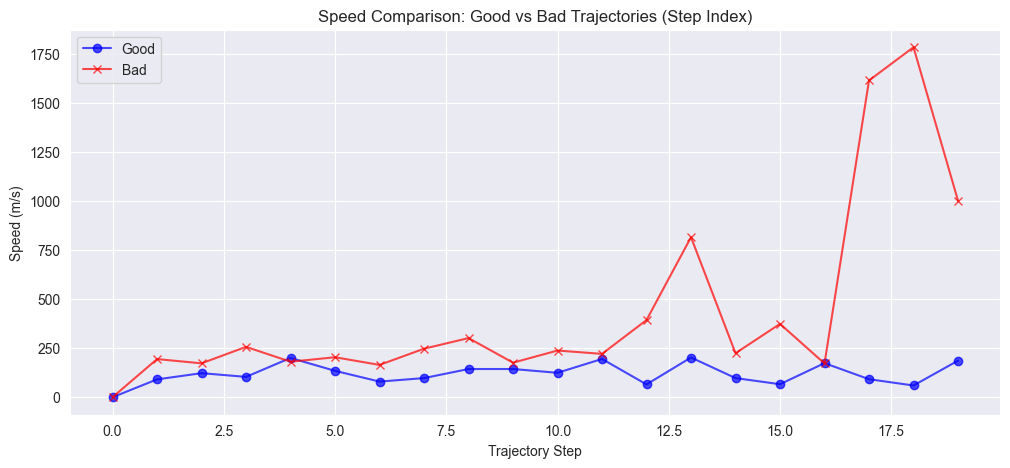

In [156]:
# Visualisation of the speed for a good vs a bad trajectory over time.
def plot_speed_over_steps(good_traj, bad_traj, label_good="Good", label_bad="Bad"):
    df_good = pointwise(good_traj)
    df_bad = pointwise(bad_traj)

    plt.figure(figsize=(12,5))

    # Step indices
    steps_good = range(len(df_good))
    steps_bad = range(len(df_bad))

    plt.plot(steps_good, df_good['speed_m_s'], '-o', color='blue', alpha=0.7, label=label_good)
    plt.plot(steps_bad, df_bad['speed_m_s'], '-x', color='red', alpha=0.7, label=label_bad)

    plt.xlabel("Trajectory Step")
    plt.ylabel("Speed (m/s)")
    plt.title("Speed Comparison: Good vs Bad Trajectories (Step Index)")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_speed_over_steps(good_trajectories[186], bad_trajectories[786])


In [157]:
# Building the model
X = df_features.drop(columns=['label'])
y = df_features['label']

In [158]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

Train samples: 1600, Test samples: 400


In [159]:
rf = RandomForestClassifier(
    n_estimators=300,      # number of trees
    max_depth=None,        # let the trees grow fully
    random_state=42,
    n_jobs=-1              # use all CPU cores
)

rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [160]:
# Predictions
y_pred = rf.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9925

Confusion Matrix:
 [[198   2]
 [  1 199]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       200
           1       0.99      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



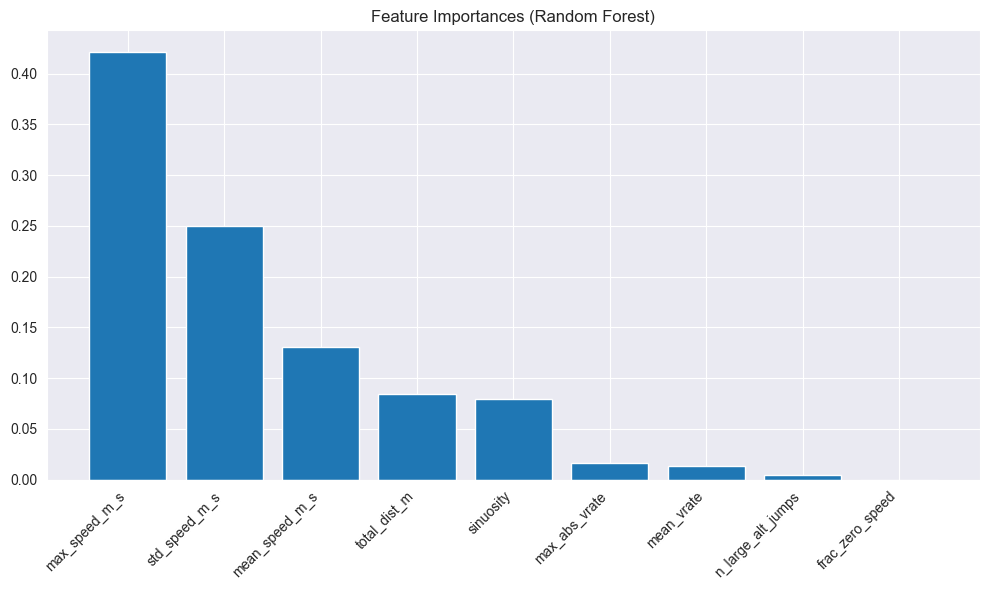

In [161]:
# Visual representation of the importance of different features
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(10,6))
plt.bar(range(len(features)), importances[indices], align='center')
plt.xticks(range(len(features)), features[indices], rotation=45, ha='right')
plt.title("Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

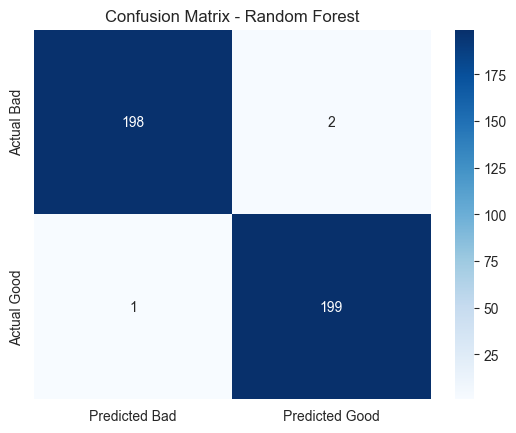

In [162]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Bad", "Predicted Good"],
            yticklabels=["Actual Bad", "Actual Good"])
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [163]:
# Dropping the two less-useful features
X = df_features.drop(columns=['label', 'frac_zero_speed', 'n_large_alt_jumps'])
y = df_features['label']

print("Using these features for training:")
print(X.columns.tolist())
print(f"\nShape of feature matrix: {X.shape}")

Using these features for training:
['mean_speed_m_s', 'std_speed_m_s', 'max_speed_m_s', 'mean_vrate', 'max_abs_vrate', 'total_dist_m', 'sinuosity']

Shape of feature matrix: (2000, 7)


In [164]:
# Building a new model
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [165]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [166]:
y_pred = rf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9950

Confusion Matrix:
 [[198   2]
 [  0 200]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       200
           1       0.99      1.00      1.00       200

    accuracy                           0.99       400
   macro avg       1.00      0.99      0.99       400
weighted avg       1.00      0.99      0.99       400



In [167]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy', n_jobs=-1)

print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy: {:.4f}".format(cv_scores.mean()))
print("Standard deviation: {:.4f}".format(cv_scores.std()))

Cross-validation scores: [0.9975 0.9925 1.     0.99   0.9975]
Mean CV accuracy: 0.9955
Standard deviation: 0.0037


In [168]:
# Calculating the upper limit of the range for normal trajectories for every feature
df_good = df_features[df_features['label'] == 1].drop(columns='label')

# Calculate upper limits (mean + 2*std)
upper_limits = pd.Series(index=df_good.columns, dtype=float)

for col in df_good.columns:
    mean_val = df_good[col].mean()
    std_val = df_good[col].std()
    upper_limits[col] = mean_val + 2*std_val

upper_limits = upper_limits.round(2)

display(upper_limits)

mean_speed_m_s         204.70
std_speed_m_s          165.62
max_speed_m_s          754.05
mean_vrate              15.78
max_abs_vrate           44.34
total_dist_m         26011.95
sinuosity                2.89
frac_zero_speed          0.05
n_large_alt_jumps       18.69
dtype: float64

In [169]:
# Calculate the lower limit for total_dist_m for good trajectories
df_good = df_features[df_features['label'] == 1].drop(columns='label')

mean_dist = df_good['total_dist_m'].mean()
std_dist = df_good['total_dist_m'].std()

# Lower limit (mean - 2*std)
lower_limit_dist = max(0, mean_dist - 2 * std_dist)
print(lower_limit_dist)

1663.7057171684974


In [170]:
#Analyzes a trajectory and explains potential problems based on learned model features
def explain_trajectory(traj, model, thresholds=None):
    feats = summarize(traj)

    feats = {k: v for k, v in feats.items() if k not in ['frac_zero_speed', 'n_large_alt_jumps']}

    X_sample = pd.DataFrame([feats])

    pred = model.predict(X_sample)[0]
    print("Trajectory Analysis")
    print("-------------------------")
    print(f"Predicted label: {'GOOD' if pred==1 else 'BAD'}")

    issues = []
    if feats['max_speed_m_s'] > 754:
        issues.append("Extremely high max speed (possible GPS spike)")
    if feats['std_speed_m_s'] > 165:
        issues.append("Large speed variation (unstable trajectory)")
    if feats['sinuosity'] > 2.89:
        issues.append("Path is too curved or inconsistent")
    if abs(feats['mean_vrate']) > 15:
        issues.append("Excessive vertical rate (possible altitude jumps)")
    if feats['total_dist_m'] < 1664:
        issues.append("Very short movement distance (possible incomplete track)")
    if feats['total_dist_m'] > 26000:
        issues.append("Very long movement distance")

    if issues:
        print("Potential Issues:")
        for i in issues:
            print(" -", i)
    else:
        print("Trajectory appears smooth and consistent.")


In [171]:
# Testing the function
print("Example GOOD trajectory:")
explain_trajectory(good_trajectories[10], rf)

Example GOOD trajectory:
Trajectory Analysis
-------------------------
Predicted label: GOOD
Trajectory appears smooth and consistent.


In [172]:
print("\nExample BAD trajectory:")
explain_trajectory(bad_trajectories[155], rf)


Example BAD trajectory:
Trajectory Analysis
-------------------------
Predicted label: BAD
Potential Issues:
 - Extremely high max speed (possible GPS spike)
 - Large speed variation (unstable trajectory)
 - Very long movement distance


Starting to build percentage estimation model here.

In [173]:
def bearing_deg(lat1, lon1, lat2, lon2):
    #Forward azimuth A->B in degrees [0, 360)
    φ1, φ2 = radians(lat1), radians(lat2)
    dλ = radians(lon2 - lon1)
    x = sin(dλ) * cos(φ2)
    y = cos(φ1) * sin(φ2) - sin(φ1) * cos(φ2) * cos(dλ)
    return (degrees(atan2(x, y)) + 360.0) % 360.0

def angle_diff_deg(a, b):
    #Smallest signed angular difference a->b in [-180, 180]
    return (b - a + 180.0) % 360.0 - 180.0

In [174]:
def pointwise_dir(traj):
    df = pd.DataFrame(traj, columns=['t', 'lat', 'lon', 'alt_FL']).astype(float)

    # time delta
    df['dt'] = df['t'].diff().fillna(1.0)
    df.loc[df['dt'] == 0, 'dt'] = 1.0  # guard

    dists = [0.0]
    for i in range(1, len(df)):
        dists.append(haversine_m(df.loc[i - 1, 'lat'], df.loc[i - 1, 'lon'],
                                 df.loc[i, 'lat'], df.loc[i, 'lon']))
    df['dist_m'] = dists
    df['speed_m_s'] = df['dist_m'] / df['dt']

    # vertical rate (FL/s)
    df['vertical_rate_FL_s'] = df['alt_FL'].diff() / df['dt']
    df['vertical_rate_FL_s'] = df['vertical_rate_FL_s'].fillna(0.0)

    # bearing A->B
    brngs = [np.nan]
    for i in range(1, len(df)):
        brngs.append(bearing_deg(df.loc[i - 1, 'lat'], df.loc[i - 1, 'lon'],
                                 df.loc[i, 'lat'], df.loc[i, 'lon']))
    df['bearing_deg'] = brngs

    # turn and turn-rate
    turns = [np.nan]
    for i in range(1, len(df)):
        a = df.loc[i - 1, 'bearing_deg']
        b = df.loc[i, 'bearing_deg']
        turns.append(np.nan if (np.isnan(a) or np.isnan(b)) else angle_diff_deg(a, b))
    df['turn_deg'] = turns
    df['turn_rate_deg_s'] = df['turn_deg'] / df['dt']

    return df

In [175]:
#Dropping distance feature and adding direction feature
def summarize_dir_full(traj):
    df = pointwise_dir(traj)

    feats = {}
    feats['mean_speed_m_s'] = float(df['speed_m_s'].mean())
    feats['std_speed_m_s'] = float(df['speed_m_s'].std())
    feats['max_speed_m_s'] = float(df['speed_m_s'].max())

    feats['mean_vrate'] = float(df['vertical_rate_FL_s'].mean())
    feats['max_abs_vrate'] = float(np.abs(df['vertical_rate_FL_s']).max())

    total_dist = float(df['dist_m'].sum())  # internal calculation only
    lat1, lon1 = df.loc[0, 'lat'], df.loc[0, 'lon']
    lat2, lon2 = df.loc[len(df) - 1, 'lat'], df.loc[len(df) - 1, 'lon']
    crow = haversine_m(lat1, lon1, lat2, lon2)
    feats['sinuosity'] = float(total_dist / crow) if crow > 0 else 1.0

    turn = df['turn_deg'].dropna()
    trate = df['turn_rate_deg_s'].dropna()

    feats['mean_abs_turn_deg'] = float(np.abs(turn).mean() if len(turn) else 0.0)
    feats['max_abs_turn_deg'] = float(np.abs(turn).max() if len(turn) else 0.0)
    feats['mean_abs_turn_rate_deg_s'] = float(np.abs(trate).mean() if len(trate) else 0.0)

    return feats


In [176]:
features_list_dir, labels_dir = [], []

for traj in good_trajectories:
    features_list_dir.append(summarize_dir_full(traj))
    labels_dir.append(1)

for traj in bad_trajectories:
    features_list_dir.append(summarize_dir_full(traj))
    labels_dir.append(0)

df_features_dir = pd.DataFrame(features_list_dir)
df_features_dir['label'] = labels_dir
df_features_dir = df_features_dir.sample(frac=1, random_state=42).reset_index(drop=True)
display(df_features_dir.head())

,mean_speed_m_s,std_speed_m_s,max_speed_m_s,mean_vrate,max_abs_vrate,sinuosity,mean_abs_turn_deg,max_abs_turn_deg,mean_abs_turn_rate_deg_s,label
0,230.757091,251.929412,1186.203620,8.277679,73.66,2.719781,30.220670,179.880713,4.795893,0
1,86.981668,46.004122,174.002315,-2.467429,10.16,1.141795,5.308767,17.136813,0.841196,1
2,579.040031,978.270685,3193.929743,0.054429,1.27,1.879839,30.153185,179.957946,4.784856,0
3,22.785404,19.565986,86.936458,-0.426357,2.54,1.060240,6.796564,17.528455,1.064609,1
4,642.592071,1001.183172,3234.611985,-9.597571,78.74,1.740203,40.103049,179.906191,6.436233,0


In [177]:
good_only = df_features_dir[df_features_dir['label'] == 1].drop(columns='label')
good_only = good_only.replace([np.inf, -np.inf], np.nan).dropna()

mu_good = good_only.mean(numeric_only=True)
std_good = good_only.std(numeric_only=True).replace(0, 1e-9)

quality_features = [c for c in df_features_dir.columns if c != 'label']

Trajectory quality estimation based on good trajectory data

In [178]:
#Statistics based quality estimation (based on statistics extracted from good trajectories)
def quality_from_features(feats):
    penalties = []

    # z-score distance from good (beyond 2 std)
    for feat in quality_features:
        x = feats[feat]
        mu = mu_good[feat]
        sd = std_good[feat]

        z = abs(x - mu) / sd
        excess = max(0, z - 2)   # anything beyond 2 std is penalized
        penalty = min(excess / 3, 1)  # saturate by ~5 std
        penalties.append(penalty)

    avg_penalty = np.mean(penalties)
    quality = (1 - avg_penalty) * 100
    return round(float(np.clip(quality, 0, 100)), 2)

In [179]:
def get_quality_percent(traj):
    feats = summarize_dir_full(traj)
    return quality_from_features(feats)

In [180]:
print("Quality % (good example):", get_quality_percent(good_trajectories[0]))
print("Quality % (bad example): ", get_quality_percent(bad_trajectories[0]))

Quality % (good example): 100.0
Quality % (bad example):  41.03


In [181]:
# pick 5 random good and 5 random bad
test_good = random.sample(good_trajectories, 5)
test_bad = random.sample(bad_trajectories, 5)

print("=== Testing GOOD trajectories ===")
for i, traj in enumerate(test_good, start=1):
    q = get_quality_percent(traj)
    print(f"Good Trajectory {i}: Quality = {q}%")

print("\n=== Testing BAD trajectories ===")
for i, traj in enumerate(test_bad, start=1):
    q = get_quality_percent(traj)
    print(f"Bad Trajectory {i}:  Quality = {q}%")

=== Testing GOOD trajectories ===
Good Trajectory 1: Quality = 100.0%
Good Trajectory 2: Quality = 100.0%
Good Trajectory 3: Quality = 100.0%
Good Trajectory 4: Quality = 100.0%
Good Trajectory 5: Quality = 100.0%

=== Testing BAD trajectories ===
Bad Trajectory 1:  Quality = 68.07%
Bad Trajectory 2:  Quality = 44.59%
Bad Trajectory 3:  Quality = 45.07%
Bad Trajectory 4:  Quality = 33.33%
Bad Trajectory 5:  Quality = 38.76%


Trajectory quality estimation based on universal data

In [183]:
# Universal "normal" ranges for the direction-based features
UNIVERSAL_NORMAL_RANGES = {
    # speed statistics (m/s)
    'mean_speed_m_s': (80.0, 280.0),  # typical cruise-ish range
    'std_speed_m_s': (0.0, 80.0),  # too high => very unstable speeds
    'max_speed_m_s': (100.0, 320.0),  # >320 m/s ~ >1150 km/h => suspicious

    # vertical motion (FL/s)
    'mean_vrate': (-10.0, 10.0),  # average climb/descent rate
    'max_abs_vrate': (0.0, 25.0),  # extremely high vertical rate is odd

    # geometry / turning
    'sinuosity': (1.0, 2.5),  # >2.5 means very wiggly / backtracking
    'mean_abs_turn_deg': (0.0, 25.0),  # average turn angle per step
    'max_abs_turn_deg': (0.0, 120.0),  # single extreme U-turns
    'mean_abs_turn_rate_deg_s': (0.0, 4.0),  # how fast we turn per second
}


def quality_from_features_universal(feats):

    penalties = []

    for feat, (low, high) in UNIVERSAL_NORMAL_RANGES.items():
        x = feats[feat]

        # within normal range → no penalty
        if low <= x <= high:
            penalties.append(0.0)
            continue

        # how far outside the range?
        if x < low:
            diff = low - x
            span = max(low, 1e-6)  # scale by lower bound
        else:  # x > high
            diff = x - high
            span = max(high - low, 1e-6)  # scale by range width

        rel = diff / span
        penalty = min(rel, 1.0)  # cap at 1
        penalties.append(penalty)

    if not penalties:
        return 100.0

    avg_penalty = float(np.mean(penalties))
    quality = (1.0 - avg_penalty) * 100.0
    return round(float(np.clip(quality, 0.0, 100.0)), 2)


def get_quality_percent_aggressive(traj):

    feats = summarize_dir_full(traj)
    return quality_from_features_universal(feats)


In [187]:
#Testing the aggressive quality estimator
print("Universal aggressive quality % (good example):", get_quality_percent_aggressive(good_trajectories[0]))
print("Universal aggressive quality % (bad example): ", get_quality_percent_aggressive(bad_trajectories[0]))

test_good = random.sample(good_trajectories, 3)
test_bad = random.sample(bad_trajectories, 3)

print("\n=== Universal aggressive: GOOD trajectories ===")
for i, traj in enumerate(test_good, start=1):
    q = get_quality_percent_aggressive(traj)
    print(f"Good Trajectory {i}: Quality = {q}%")

print("\n=== Universal aggressive: BAD trajectories ===")
for i, traj in enumerate(test_bad, start=1):
    q = get_quality_percent_aggressive(traj)
    print(f"Bad Trajectory {i}:  Quality = {q}%")


Universal aggressive quality % (good example): 99.82
Universal aggressive quality % (bad example):  63.1

=== Universal aggressive: GOOD trajectories ===
Good Trajectory 1: Quality = 98.49%
Good Trajectory 2: Quality = 98.35%
Good Trajectory 3: Quality = 99.96%

=== Universal aggressive: BAD trajectories ===
Bad Trajectory 1:  Quality = 72.64%
Bad Trajectory 2:  Quality = 56.66%
Bad Trajectory 3:  Quality = 63.24%


In [1]:
from trajectory_tools import (
    estimate_quality_stats,
    estimate_quality_universal,
    optimize_trajectory_aggressive,
    optimize_trajectory_stats_based,
)
